In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

from src.data.feature_extractor import FeatureExtractor
from src.data.importer import DataImporter
from src.data.ratings_dataset import RatingsDataset
from src.model.candidate_generation import CandidateGeneration
from src.model.popularity import Popularity
from src.trainer import Trainer
from src.utils import get_device


### Fetch MovieLens100k data

In [7]:
data_importer = DataImporter('http://files.grouplens.org/datasets/movielens/ml-100k.zip')
users_df, movies_df, genres, ratings_df = data_importer.import_data()

Data already exists


### Generate features and create examples df

In [8]:
f_extractor = FeatureExtractor(window_size=50)
examples_df = f_extractor.fit_transform(
    genres=genres,
    movies_df=movies_df,
    users_df=users_df,
    ratings_df=ratings_df
)

One-Hot user occupation matrix shape (943, 21)
One-Hot user gender matrix shape (943, 2)
One-Hot user geo area matrix shape (943, 4)
Using 108 examples per user_id
Using 25 examples per label
Examples shape  (38175, 7)


## Split train/validation examples

In [9]:
train_df, val_df = train_test_split(examples_df)

# Train Loader
train_dataset = RatingsDataset.from_df(train_df)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

# Validation Loader
val_dataset = RatingsDataset.from_df(val_df)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

### Train Candidate generation model

In [10]:
EMBEDDING_DIMS = 256
DENSE_UNITS = 256
USER_DIM = 64
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

In [11]:
device = get_device()

model = CandidateGeneration(
    n_items=movies_df.index.astype(int).max() + 2,
    n_search_items=len(genres) + 1,
    n_features=len(examples_df.iloc[0]['features']),
    embedding_dim=EMBEDDING_DIMS,
    fc_layers=(2048, 1024, 512, 256),
    user_dim=USER_DIM
).to(device)

opt = Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
crit = CrossEntropyLoss().to(device)

CUDA is not available.  Training on CPU ...


In [12]:
trainer = Trainer(model, opt, crit, device)
train_losses, val_losses = trainer.train(train_loader, val_loader, epochs=7)

Epoch 1/7, train loss: 7.4264, val loss: 7.4273, time: 8.55s
Epoch 2/7, train loss: 7.4179, val loss: 7.4180, time: 8.57s
Epoch 3/7, train loss: 7.4119, val loss: 7.4136, time: 10.53s
Epoch 4/7, train loss: 7.4076, val loss: 7.4089, time: 11.88s
Epoch 5/7, train loss: 7.4018, val loss: 7.4046, time: 10.43s
Epoch 6/7, train loss: 7.3967, val loss: 7.4020, time: 9.45s
Epoch 7/7, train loss: 7.3924, val loss: 7.3961, time: 8.54s


<AxesSubplot:>

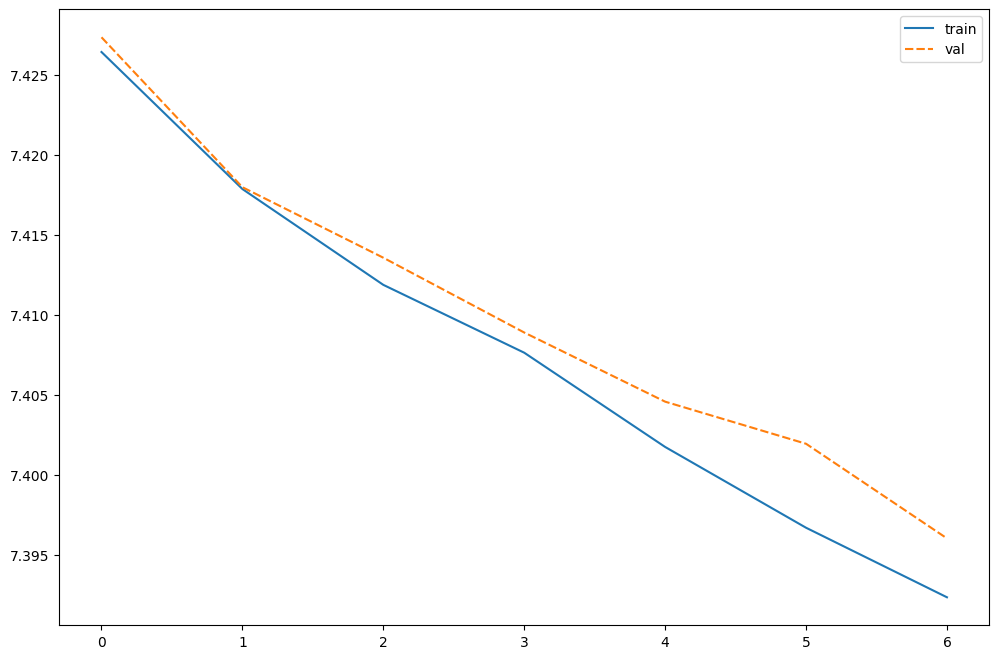

In [13]:
_, ax = plt.subplots(1, figsize=(12, 8))
sns.lineplot(data=pd.DataFrame({'train': train_losses, 'val': val_losses}), ax=ax)

### Evaluate Original Model


In [14]:
k = 10

In [15]:
print(f'candidate generation validation mrr @ {k}: ', model.mrr(val_loader, k))
print(f'candidate generation validation hit rate @ {k}: ', model.hit_rate(val_loader, k))

validation mrr @ 10:  0.052883095255023556
validation hit rate @ 10:  0.08162257301026958


### POP model (Baseline)

In [40]:
pop = Popularity()
pop.fit(ratings_df)

In [42]:
print(f'popularity model validation mrr @ {k}: ', pop.mrr(val_loader, k))
print(f'popularity model validation hit rate @ {k}: ', pop.hit_rate(val_loader, k))

popularity model validation mrr @ 10:  0.0006007858204324485
popularity model validation hit rate @ 10:  0.0023643092105263158


### Compare models

In [45]:
results_df = pd.DataFrame(columns=['model', 'metric', 'k', 'score'])

In [48]:
for m, name in [(model, 'candidate_generation'), (pop, 'pop')]:
    for k in [5, 10, 20]:
        results_df.loc[results_df.shape[0]] = (name, 'mrr', k, m.mrr(val_loader, k))
        results_df.loc[results_df.shape[0]] = (name, 'hit_rate', k, m.hit_rate(val_loader, k))

,model,metric,k,score
1,candidate_generation,hit_rate,5,0.065812
7,pop,hit_rate,5,0.001336
0,candidate_generation,mrr,5,0.050778
6,pop,mrr,5,0.000452
3,candidate_generation,hit_rate,10,0.081623
9,pop,hit_rate,10,0.002364
2,candidate_generation,mrr,10,0.052883
8,pop,mrr,10,0.000601
5,candidate_generation,hit_rate,20,0.099444
11,pop,hit_rate,20,0.004215


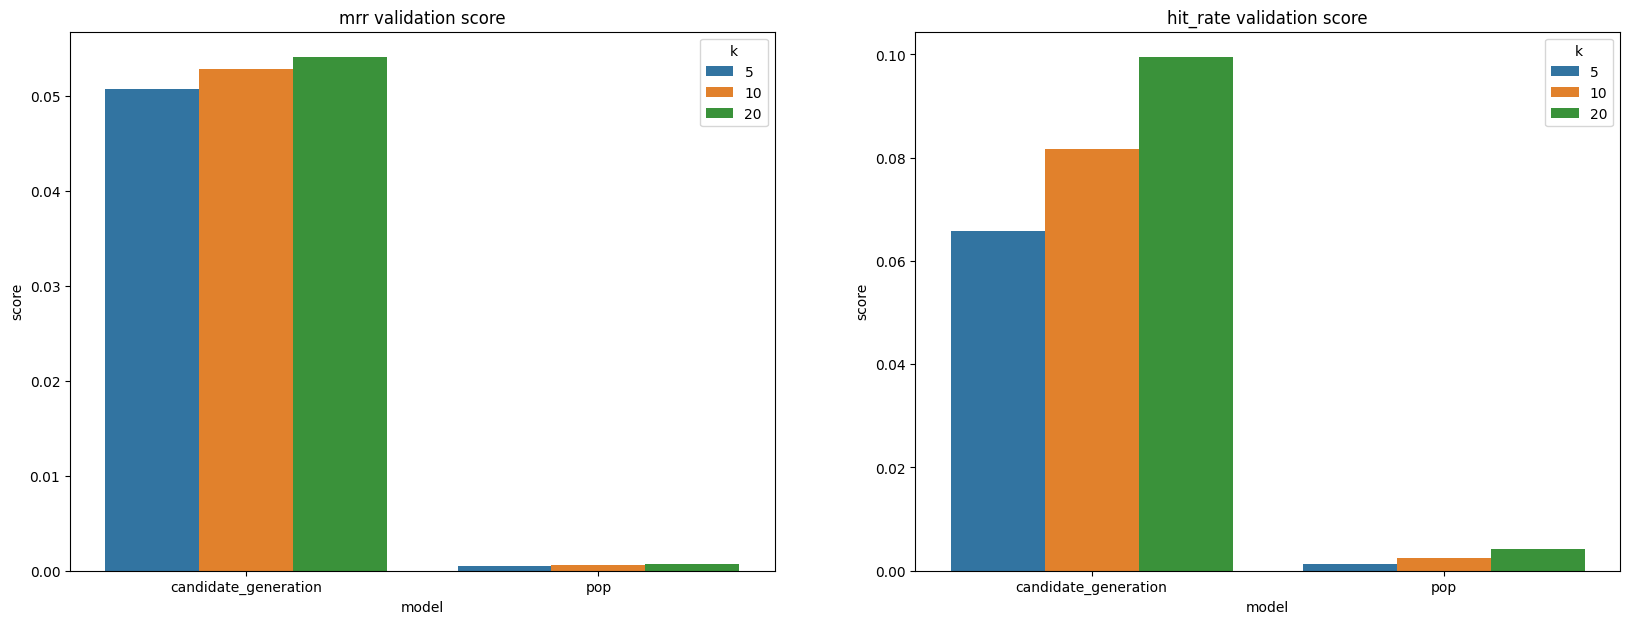

In [62]:
_, ax = plt.subplots(1,2, figsize=(20,7))
for i, metric in enumerate(['mrr', 'hit_rate']):
    sns.barplot(data=results_df.loc[results_df.metric==metric].drop(columns=['metric']), y='score', x='model', hue='k', ax=ax[i])
    ax[i].set(title=f'{metric} validation score')